In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib qt

In [2]:
with open('data.env', "r") as f:
    lambdas = []
    top = []
    bottom = []
    for line in f.readlines():
        if "'" not in line:
            try:
                l, t, b = line.split()
                lambdas.append(float(l))
                top.append(float(t))
                bottom.append(float(b))
            except:
                pass
top = np.array(top)
lambdas = np.array(lambdas)
bottom = np.array(bottom)

In [3]:
# Load spectrum data:
df = pd.read_excel('espectro.xlsx')
lambdas2 = df['Lambda (nm)'].values
film = df['Película'].values
glass = df['Vidrio'].values
cut = np.where((lambdas2 > lambdas[0]-1) & (lambdas2 < lambdas[-1]+1))
lambdas2 = lambdas2[cut]
film = film[cut]
glass = glass[cut]
s = 1/glass + np.sqrt(1/glass - 1)

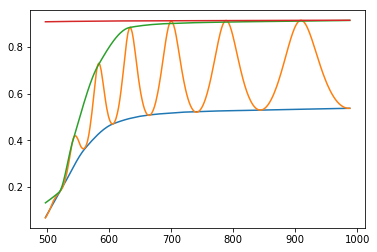

In [4]:
plt.plot(lambdas, bottom)
plt.plot(lambdas, film)
plt.plot(lambdas, top)
plt.plot(lambdas, glass)
plt.show()

In [5]:
# Ec. 11 de Swanepoel:

N = 2*s*(top-bottom)/(top*bottom) + (s*s+1)/2
n = np.sqrt(N + np.sqrt(N*N - s*s))

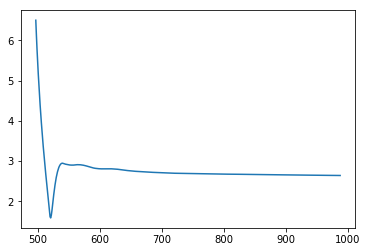

In [6]:
plt.plot(lambdas, n)
plt.show()

In [7]:
with open('data.tan', "r") as f:
    critical_points = []
    for line in f.readlines():
        if "'" not in line:
            try:
                c, _a, _b = line.split()
                critical_points.append(int(float(c)))
            except:
                pass
d_values = []
for i in range(2, len(critical_points)):
    # Ec. 23 Swanepoel:
    lam1 = critical_points[i-2]
    lam2 = critical_points[i]
    n1 = n[np.where(lambdas==lam1)]
    n2 = n[np.where(lambdas==lam2)]
    d = lam1*lam2/(2*abs(lam1*n2 - lam2*n1))
    d_values.append(d[0])

In [8]:
d_values

[52.88323195284552,
 239.6426500838279,
 322.51320268525467,
 926.02641571538823,
 914.72531645372044,
 976.88675077748712,
 985.65108162369916,
 936.33508777696909,
 1020.8596170994304,
 1048.3876110300828,
 1047.6028410969373,
 1044.5909190842942,
 1035.6737316755534]

In [9]:
# First estimate of d value:

true_d = d_values[3:]
print(np.mean(true_d), np.std(true_d))
d1 = np.mean(true_d)

993.673937233 50.4385637432


In [10]:
n_critical = []
for c in critical_points:
    n_crit = n[np.where(lambdas==c)][0]
    n_critical.append(n_crit)

In [11]:
n_over_lambda = np.array(n_critical)/np.array(critical_points)

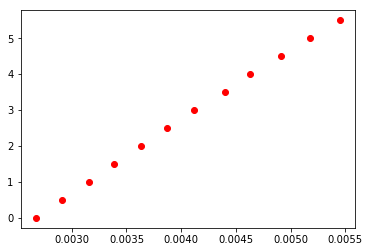

In [12]:
l = np.arange(len(n_critical))[::-1]

plt.plot(n_over_lambda[3:], l[3:]/2, 'ro')
plt.show()

In [13]:
z = np.polyfit(n_over_lambda[3:], l[3:]/2, 1)
d2 = z[0]/2
print(d2)
p = np.poly1d(z)

991.853895094


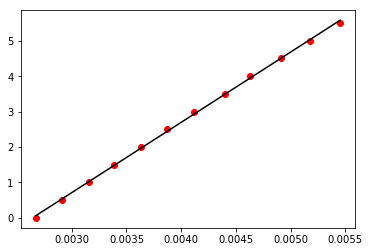

In [14]:
plt.plot(n_over_lambda[3:], l[3:]/2, 'ro')
plt.plot(n_over_lambda[3:], p(n_over_lambda[3:]), 'k-')
plt.show()

In [15]:
# Ec. 16
Ti = 2*top*bottom/(top+bottom)
# Ec. 15
F = 8*n*n*s/Ti
x = (F - np.sqrt(F*F-(n*n-1)**3*(n*n-s*s*s*s)))/((n-1)**3*(n-s*s))

In [16]:
alpha1 = -np.log(x)/d1
alpha2 = -np.log(x)/d2

In [17]:
# Swaneopel function for transmision:
def T_at_lambda(lam, n, s, d, alpha):
    """
    n and alpha are NOT functions of lam in this function.
    The function computes equaiton (4) of Swanepoel's paper.
    """
    A = 16*n*n*s
    B = (n+1)**3*(n+s*s)
    C = 2*(n*n-1)*(n*n-s*s)
    D = (n-1)**3*(n-s*s)
    phi = 4*np.pi*n*d/lam
    x = np.exp(-alpha*d)
    return A*x/(B-C*x*np.cos(phi)+ D*x*x)

In [18]:
predicted1 = [T_at_lambda(lambdas[i], n[i], s[i], d1, alpha1[i]) for i in range(len(lambdas))]
predicted2 = [T_at_lambda(lambdas[i], n[i], s[i], d2, alpha1[i]) for i in range(len(lambdas))]

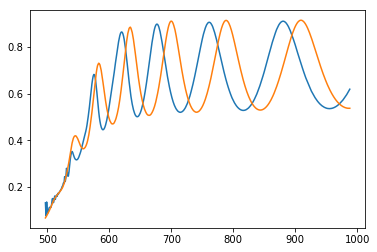

In [19]:
plt.plot(lambdas, predicted1)
plt.plot(lambdas, film)
plt.show()

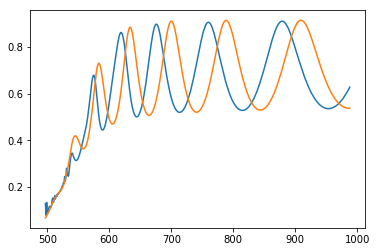

In [20]:
plt.plot(lambdas, predicted2)
plt.plot(lambdas, film)
plt.show()

In [21]:
from functools import partial
from scipy.optimize import curve_fit

def fit_data(lam, d, n, s, x, lambdas):
    idx = np.where(lambdas == lam)
    n_indiv = n[idx][0]
    s_indiv = s[idx][0]
    x_indiv = x[idx][0]
    alpha_indiv = -np.log(x_indiv)/d
    return T_at_lambda(lam, n_indiv, s_indiv, d, alpha_indiv)

fit_func = partial(fit_data, n=n, s=s, x=x, lambdas=lambdas)
popt, pcov = curve_fit(fit_func, lambdas, film, p0=[1030])

In [22]:
d_best = popt[0]

In [23]:
alpha_best = -np.log(x)/d_best
predicted_best = [fit_func(lam, d_best) for lam in lambdas]

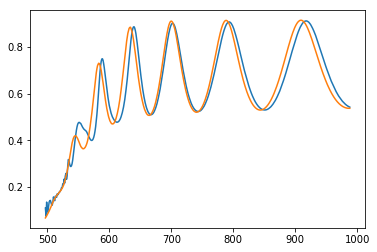

In [24]:
plt.plot(lambdas, predicted_best)
plt.plot(lambdas, film)
plt.show()

In [25]:
from scipy.optimize import minimize

def min_difference_data(d, lambdas, n, s, x, experimental):
    alpha = -np.log(x)/d
    predicted = [T_at_lambda(lambdas[i], n[i], s[i], d, alpha1[i]) for i in range(len(lambdas))]
    predicted = np.array(predicted)
    idx = np.where(lambdas > 600)
    diff = predicted[idx] - experimental[idx]
    return np.sum(diff*diff)

result = minimize(min_difference_data, args=(lambdas, n, s, x, film), bounds=([1020, 1040],), x0=[1035], method='TNC')
d_best_min = result['x']
print(d_best_min)

[ 1040.]


In [26]:
alpha_best_min = -np.log(x)/d_best_min
predicted_best_min = [fit_func(lam, d_best_min) for lam in lambdas]

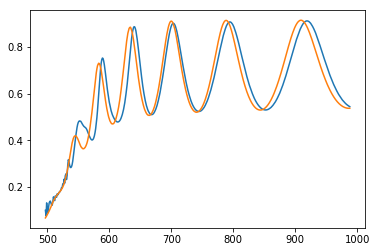

In [27]:
plt.plot(lambdas, predicted_best_min)
plt.plot(lambdas, film)
plt.show()

1029.83967936


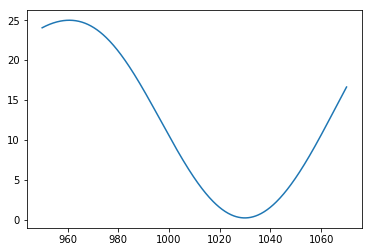

In [28]:
# This plot shows that the actual minimum is

d_list = np.linspace(950, 1070, 500)
diffs = [min_difference_data(d, lambdas, n, s, x, film) for d in d_list]
idx_min = np.where(np.array(diffs)==min(diffs))
the_real_d = d_list[idx_min][0]
print(the_real_d)
plt.plot(d_list, diffs)
plt.show()

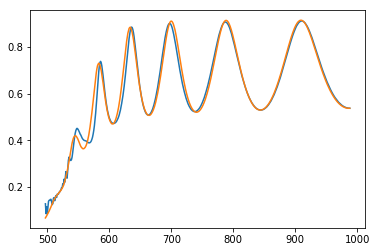

In [29]:
real_alpha = -np.log(x)/the_real_d
real_predicted = [fit_func(lam, the_real_d) for lam in lambdas]
plt.plot(lambdas, real_predicted)
plt.plot(lambdas, film)
plt.show()

# Tauc

In [34]:
#lambda * nu = c
c = 299792458000000000  #nm per second
nus = c/lambdas
h = 4.135667662e-15 # eV * s

In [56]:
ns = [2., 2./3., 0.5, 1./3.]
labels = ["2", "2/3", "1/2", "1/3"]
bounds = [[2.32, 2.37], [2.18, 2.3], [2.18, 2.3], [2.18, 2.3]]

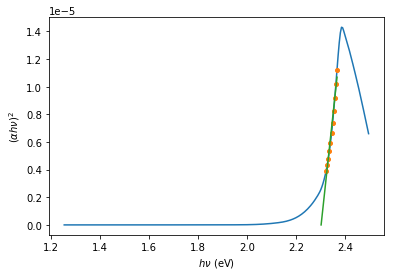

2 2.30129107628


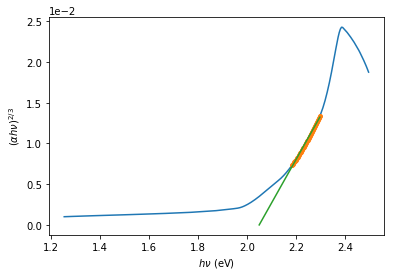

2/3 2.04914062896


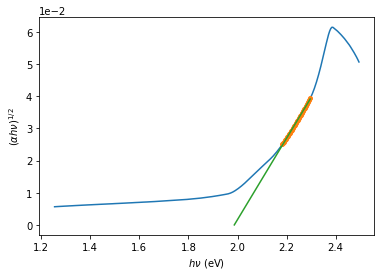

1/2 1.98691138007


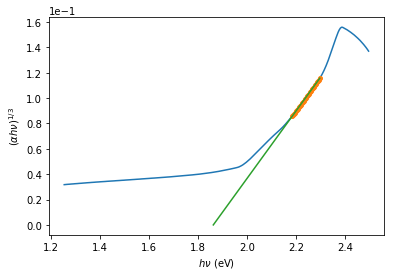

1/3 1.86215009812


In [65]:
for l, n in enumerate(ns):
    y = (real_alpha*h*nus)**n
    x = h*nus
    bmin, bmax = bounds[l]
    idx = np.where((x>bmin) & (x<bmax))
    xfit = x[idx]
    yfit = y[idx]
    z = np.polyfit(xfit, yfit, 1)
    p = np.poly1d(z)
    x0 = -z[1]/z[0]
    x_line_plot = [x0, xfit[0]]
    yline = p(np.array(x_line_plot))
    plt.plot(x, y)
    plt.plot(xfit, yfit, marker='o', ms=4, lw=0)
    plt.plot(x_line_plot, yline)
    plt.xlabel(r"$h\nu$ (eV)")
    plt.ylabel(r"$(\alpha h \nu)^{{{0}}}$".format(labels[l]))
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)
    plt.show()
    gap = -z[1]/z[0]
    print(labels[l], gap)